In [2]:
!pip install wget
!pip install thop

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=2978990e7c1f8fa836bffc56c6263aa8fc7cc5702a7af26586b3263bc428d039
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [46]:
import os
import os.path
import wget
from zipfile import ZipFile
import random
from sklearn import metrics
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
import copy
import numpy as np
from collections import defaultdict
import torch
import torch.backends.cudnn
import torch.cuda
from torch import nn, autograd
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.models as models
import pickle
from datetime import datetime

In [36]:
class Arguments:
    def __init__(self):
        self.epochs = 100
        self.num_users = 10
        self.frac = 0.2
        self.local_ep = 5
        self.local_bs = 32
        self.test_bs = 32
        self.lr = 0.001
        self.momentum = 0.9
        self.split = 'user'
        
        self.model = 'mobilenet'
        
        self.rebuild = 1
        self.struct = 1
        self.dataset = 'imagenet'
        self.iid = False
        self.alpha = 0.8
        self.num_classes = 200
        self.num_channels = 3
        self.gpu = 0
        self.stopping_rounds = 10
        self.verbose = 1
        self.debug = 1
        self.seed = 1

In [37]:
def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[k] += w[i][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg

def test_img(net_g, datatest, args):
    net_g.eval()
    # testing
    test_loss_batch = []
    test_loss = 0
    correct = 0
    data_loader = DataLoader(datatest, batch_size=args.test_bs)
    l = len(data_loader)
    with torch.no_grad():
        for idx, (data, target) in enumerate(data_loader):
            if args.gpu != -1:
                data, target = data.to(args.device), target.to(args.device)
            log_probs = net_g(data)
            # sum up batch loss
            test_loss += F.cross_entropy(log_probs, target, reduction='sum').item()
            # get the index of the max log-probability
            y_pred = log_probs.data.max(1, keepdim=True)[1]
            correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum()

        test_loss /= len(data_loader.dataset)
        test_loss_batch.append(test_loss)
        accuracy = 100.00 * correct.item() / len(data_loader.dataset)
    # if args.verbose:
    print('\nTest set: Average loss: {:.4f} \nAccuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset), accuracy))
    return accuracy, test_loss, test_loss_batch


class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.targets = dataset.targets
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label


class LocalUpdate(object):
    def __init__(self, args, dataset=None, idxs=None):
        self.args = args
        self.loss_func = nn.CrossEntropyLoss()
        self.selected_clients = []
        self.ldr_train = DataLoader(DatasetSplit(dataset, idxs),
                                batch_size=self.args.local_bs, shuffle=True)
        
    def train_val_split(self, dataset, idxs):
        """
        Returns train, validation and test dataloaders for a given dataset
        and user indexes.
        """
        # split indexes for train, validation, and test (80, 10, 10)
        idxs_train = idxs[:int(0.4*len(idxs))]

        trainloader = DataLoader(DatasetSplit(dataset, idxs_train),
                                batch_size=self.args.local_bs, shuffle=True)

        return trainloader

    def train(self, net):
        net.train()
        # train and update
        print('\nstart local train\n')

        # optimizer = torch.optim.SGD(net.parameters(), lr=self.args.lr, momentum=0.9, weight_decay=5e-4)
        optimizer = torch.optim.SGD(net.parameters(), lr=self.args.lr, momentum=0.5)
        
        # optimizer = torch.optim.Adam(net.parameters(), lr=self.args.lr, weight_decay=1e-4)
        epoch_loss = []
        for iter in range(self.args.local_ep):
            batch_loss = []
            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = images.to(self.args.device), labels.to(self.args.device)
                net.zero_grad()
                log_probs = net(images)
                loss = self.loss_func(log_probs, labels)
                loss.backward()
                optimizer.step()
                if self.args.verbose and batch_idx % 10 == 0:
                    print('Update Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        iter, batch_idx * len(images), len(self.ldr_train.dataset),
                               100. * batch_idx / len(self.ldr_train), loss.item()))
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))
        return net.state_dict(), sum(epoch_loss) / len(epoch_loss)
    
    
def parse_classes(file):
    classes = []
    filenames = []
    with open(file) as f:
        lines = f.readlines()
    lines = [x.strip() for x in lines]
    for x in range(len(lines)):
        tokens = lines[x].split()
        classes.append(tokens[1])
        filenames.append(tokens[0])
    return filenames, classes

class TinyImageNetDataset(torch.utils.data.Dataset):
    """Dataset wrapping images and ground truths."""
    def __init__(self, img_path, gt_path, class_to_idx=None, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.gt_path = gt_path
        self.class_to_idx = class_to_idx
        self.classidx = []
        self.imgs, self.classnames = parse_classes(gt_path)
        for classname in self.classnames:
            self.classidx.append(self.class_to_idx[classname])

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, y) where y is the label of the image.
        """
        img = None
        with open(os.path.join(self.img_path, self.imgs[index]), 'rb') as f:
            img = PIL.Image.open(f).convert('RGB')
            if self.transform is not None:
                img = self.transform(img)
        y = self.classidx[index]
        return img, y

    def __len__(self):
        return len(self.imgs)

    


def imagenet_iid(dataset, num_users):
    """
    Sample I.I.D. client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items, replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users


def imagenet_noniid(dataset, no_participants, alpha=0.9):
    """
    Input: Number of participants and alpha (param for distribution)
    Output: A list of indices denoting data in CIFAR training set.
    Requires: cifar_classes, a preprocessed class-indice dictionary.
    Sample Method: take a uniformly sampled 10-dimension vector as parameters for
    dirichlet distribution to sample number of images in each class.
    """
    np.random.seed(666)
    random.seed(666)
    cifar_classes = {}
    for ind, x in enumerate(dataset):
        _, label = x
        if label in cifar_classes:
            cifar_classes[label].append(ind)
        else:
            cifar_classes[label] = [ind]

    per_participant_list = defaultdict(list)
    no_classes = len(cifar_classes.keys())
    class_size = len(cifar_classes[0])
    datasize = {}
    for n in range(no_classes):
        random.shuffle(cifar_classes[n])
        sampled_probabilities = class_size * np.random.dirichlet(
            np.array(no_participants * [alpha]))
        for user in range(no_participants):
            no_imgs = int(round(sampled_probabilities[user]))
            datasize[user, n] = no_imgs
            sampled_list = cifar_classes[n][:min(len(cifar_classes[n]), no_imgs)]
            per_participant_list[user].extend(sampled_list)
            cifar_classes[n] = cifar_classes[n][min(len(cifar_classes[n]), no_imgs):]
    train_img_size = np.zeros(no_participants)
    for i in range(no_participants):
        train_img_size[i] = sum([datasize[i,j] for j in range(200)])
    clas_weight = np.zeros((no_participants,200))
    for i in range(no_participants):
        for j in range(200):
            clas_weight[i,j] = float(datasize[i,j])/float((train_img_size[i]))
    return per_participant_list, clas_weight


def setup_seed(seed):
    torch.manual_seed(seed+1)
    torch.cuda.manual_seed_all(seed+123)
    np.random.seed(seed+1234)
    random.seed(seed+12345)
    torch.backends.cudnn.deterministic = True


def add_scalar(writer, user_num, test_result, epoch):
    test_loss, test_acc, user_loss, user_acc = test_result
    writer.add_scalar(f'user_{user_num}/global/test_loss', test_loss, epoch)
    writer.add_scalar(f'user_{user_num}/global/test_acc', test_acc, epoch)
    writer.add_scalar(f'user_{user_num}/local/test_loss', user_loss, epoch)
    writer.add_scalar(f'user_{user_num}/local/test_acc', user_acc, epoch)


def exp_details(args):
    print('\n---------------Experimental details:-------------\n')
    print(f'\tModel           : {args.model}')
    print(f'\ttLearning       : {args.lr}')
    print(f'\tGlobal Rounds   : {args.epochs}\n')

    print('\n----------------Federated parameters:------------\n')
    if args.iid:
        print('\tIID')
    else:
        print('\tNon-IID')
    print(f'\tFraction of users  : {args.frac}')
    print(f'\tLocal Batch size   : {args.local_bs}')
    print(f'\tLocal Epochs       : {args.local_ep}\n')
    return

In [38]:
# parse args
args = Arguments()
args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
setup_seed(args.seed)
exp_details(args)



---------------Experimental details:-------------

	Model           : mobilenet
	tLearning       : 0.001
	Global Rounds   : 100


----------------Federated parameters:------------

	Non-IID
	Fraction of users  : 0.2
	Local Batch size   : 32
	Local Epochs       : 5



In [40]:
# load dataset and split users
# test_loader = DataLoader(dataset_test, batch_size=1000, shuffle=False)
if args.dataset == 'imagenet':
    TINY_IMAGENET_ROOT = 'data/tiny-imagenet-200/'
    if os.path.exists('tiny-imagenet-200.zip') == False:
        print('\nDownload dataset\n')
        url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
        tiny_imgdataset = wget.download(url, out = os.getcwd())
        with ZipFile('tiny-imagenet-200.zip', 'r') as zip_ref:
            zip_ref.extractall('data/')
    else:
        print('\nDataset is already downloaded\n')


    dataset_train = datasets.ImageFolder(
        os.path.join('data/', 'tiny-imagenet-200', 'train'),
        transform=transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.RandomRotation(20),
                transforms.RandomHorizontalFlip(0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]
        )
    )
    dataset_test = TinyImageNetDataset(
        img_path=os.path.join('data/', 'tiny-imagenet-200', 'val', 'images'), 
        gt_path=os.path.join('data/', 'tiny-imagenet-200', 'val', 'val_annotations.txt'),
        class_to_idx=dataset_train.class_to_idx.copy(),
        transform=transforms.Compose(
            [
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]
        )
    )

else:
    exit('Error: unrecognized dataset')


Dataset is already downloaded



start separate dataset for non-iid
end


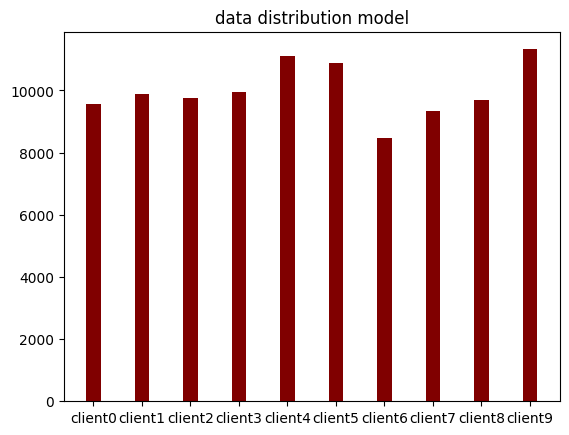

In [42]:
data_dist = []
x_client = []
if args.iid:
    print('start separate dataset for iid')
    dict_users = imagenet_iid(dataset_train, args.num_users)
    print('end')
else:
    print('start separate dataset for non-iid')
    dict_users, _ = imagenet_noniid(dataset_train, args.num_users, args.alpha)

    for k, v in dict_users.items():
        data_dist.append(len(np.array(dataset_train.targets)[v]))
        x_client.append(f'client{k}')

        writer.add_histogram(f'user_{k}/data_distribution',
                            np.array(dataset_train.targets)[v])
        writer.add_histogram(f'all_user/data_distribution',
                            np.array(dataset_train.targets)[v], global_step=k)

    plt.title("data distribution model")
    plt.bar(x_client, data_dist, color ='maroon', width = 0.3)
    plt.savefig(f"data_dist_num_users{args.num_users}_iid_{args.iid}_epochs_{args.epochs}.png") 

    print('end')

In [48]:
# build model
if args.model == 'mobilenet' and args.dataset == 'imagenet':
    # net_glob = MobileNetV2().to(args.device)
    net_glob = models.mobilenet_v3_large(pretrained=False, classes_num=200, input_size=224, width_multiplier=1).to(args.device)
    
    
else:
    exit('Error: unrecognized model')
# print(net_glob)
net_glob.train()


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [49]:
# copy weights
w_glob = net_glob.state_dict()

In [ ]:
# training
loss_train = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []
test_best_acc = 0.0

test_loss_ar = []
test_loss_peer_batch = []
tmp = 0
test_acc_graph = []
train_local_loss = {}


for iter in range(1, args.epochs + 1):
    print(f'\nGlobal epoch {iter}\n')
    w_locals, loss_locals = [], []
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    for idx in idxs_users:
        print(f'\nclient {idx}\n')
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_locals.append(w)
        loss_locals.append(loss)
        if idx in train_local_loss.keys():
            train_local_loss[idx].append(loss)
        else:
            train_local_loss[idx] = []
            train_local_loss[idx].append(loss)
        # writer.add_scalar('train loss', {f'client_{idx}': loss, iter)
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    print('==============================')
    print('Round {:3d}, Train loss {:.3f}'.format(iter, loss_avg))
    loss_train.append(loss_avg)
    writer.add_scalar('train_loss', loss_avg, iter)
    test_acc, test_loss, tmp = test_img(net_glob, dataset_test, args)
    test_loss_peer_batch.append(tmp)
    test_loss_ar.append(test_loss)
    test_acc_graph.append(test_acc)

    writer.add_scalar('test_loss', test_loss, iter)
    writer.add_scalar('test_acc', test_acc, iter)
    print('==============================')
    save_info = {
        "model": net_glob.state_dict(),
        "epoch": iter
    }
    # save model weights
    if (iter+1) % 500 == 0:
        save_path = f'./save2/{TAG}_{iter+1}es' if args.debug else f'./save/{TAG}_{iter+1}es'
        torch.save(save_info, save_path)
    if iter > 100 and test_acc > test_best_acc:
        test_best_acc = test_acc
        save_path = f'./save2/{TAG}_bst' if args.debug else f'./save/{TAG}_bst'
        torch.save(save_info, save_path)






Global epoch 1


client 1


start local train

Update Epoch: 0 [0/9886 (0%)]	Loss: 6.906347
Update Epoch: 0 [320/9886 (3%)]	Loss: 6.905664
Update Epoch: 0 [640/9886 (6%)]	Loss: 6.907110
Update Epoch: 0 [960/9886 (10%)]	Loss: 6.903666
Update Epoch: 0 [1280/9886 (13%)]	Loss: 6.907605
Update Epoch: 0 [1600/9886 (16%)]	Loss: 6.909797
Update Epoch: 0 [1920/9886 (19%)]	Loss: 6.906958
Update Epoch: 0 [2240/9886 (23%)]	Loss: 6.906594
Update Epoch: 0 [2560/9886 (26%)]	Loss: 6.904096
Update Epoch: 0 [2880/9886 (29%)]	Loss: 6.900353
Update Epoch: 0 [3200/9886 (32%)]	Loss: 6.899992
Update Epoch: 0 [3520/9886 (36%)]	Loss: 6.902014
Update Epoch: 0 [3840/9886 (39%)]	Loss: 6.901731
Update Epoch: 0 [4160/9886 (42%)]	Loss: 6.901879
Update Epoch: 0 [4480/9886 (45%)]	Loss: 6.898631
Update Epoch: 0 [4800/9886 (49%)]	Loss: 6.898637
Update Epoch: 0 [5120/9886 (52%)]	Loss: 6.899536
Update Epoch: 0 [5440/9886 (55%)]	Loss: 6.898970
Update Epoch: 0 [5760/9886 (58%)]	Loss: 6.902274
Update Epoch: 0 [6080/9886 (61

In [ ]:
with open('save/model.pkl', 'wb') as fin:
    pickle.dump(net_glob)



In [ ]:
# plot loss curve


plt.title("global model")
plt.plot(range(1, len(loss_train)+1, 1), loss_train, label='train loss')
plt.plot(range(1, len(loss_train)+1, 1), test_loss_ar, label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(fontsize=12)
plt.savefig("imgs/global model {}_{}_{}_C_{}_iid_{}.png".format(args.dataset, args.model, args.epochs, args.frac, args.iid))
plt.close()




In [ ]:
k = 0
print(train_local_loss)
for i in train_local_loss.keys():
    plt.plot(range(1, len(train_local_loss[i]) + 1, 1), train_local_loss[i], label=f'client{i}')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig("imgs/Train loss by each client {}_{}_{}_C{}_iid{}.png".format(args.dataset, args.model, args.epochs, args.frac, args.iid))
plt.close()




In [ ]:
plt.figure()
plt.plot(range(len(loss_train)), loss_train)
plt.ylabel('train_loss')
plt.savefig('imgs/fed_numUsers_{}_{}_{}_{}_C{}_iid{}.png'.format(args.num_users, args.dataset, args.model, args.epochs, args.frac, args.iid))



In [ ]:
# testing
net_glob.eval()
acc_train, loss_train = test_img(net_glob, dataset_train, args)
acc_test, loss_test = test_img(net_glob, dataset_test, args)
print("Training accuracy: {:.2f}".format(acc_train))
print("Testing accuracy: {:.2f}".format(acc_test))
writer.close()